In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:14<00:00, 190MB/s]
100% 2.29G/2.29G [00:14<00:00, 171MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip")
zip_ref.extractall("/content")
zip_ref.close()

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate
from tensorflow.keras import layers
from tensorflow.keras import models

In [7]:
train_ds = keras.utils.image_dataset_from_directory(directory="/content/chest_xray/train", labels="inferred", label_mode="int", batch_size=32, image_size=(256,256))
test_ds = keras.utils.image_dataset_from_directory(directory="/content/chest_xray/test", labels="inferred", label_mode="int", batch_size=32, image_size=(256,256))
val_ds = keras.utils.image_dataset_from_directory(directory="/content/chest_xray/val", labels="inferred", label_mode="int", batch_size=32, image_size=(256,256))

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [9]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1]


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

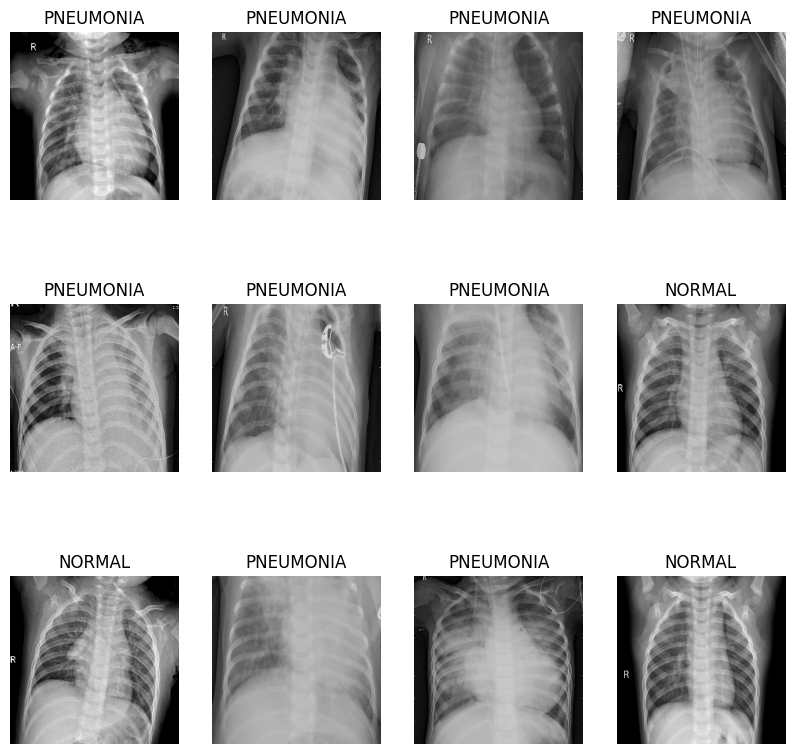

In [12]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in train_ds.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 # color images -> 3 and b/w -> 1 (0 to 255)
EPOCHS = 15

**Resizing and Rescaling**

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Data Augmentation**

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Model Building-CNN**

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
from keras.backend import binary_crossentropy
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
163/163 [==============================] - 51s 214ms/step - loss: 0.5873 - accuracy: 0.7402 - val_loss: 0.8397 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 38s 223ms/step - loss: 0.5086 - accuracy: 0.7680 - val_loss: 0.6489 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 36s 216ms/step - loss: 0.3286 - accuracy: 0.8579 - val_loss: 0.4740 - val_accuracy: 0.8750
Epoch 4/5
163/163 [==============================] - 36s 208ms/step - loss: 0.2101 - accuracy: 0.9166 - val_loss: 0.4195 - val_accuracy: 0.7500
Epoch 5/5
163/163 [==============================] - 35s 205ms/step - loss: 0.1934 - accuracy: 0.9260 - val_loss: 0.4435 - val_accuracy: 0.8750


In [20]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 3s 89ms/step - loss: 0.4181 - accuracy: 0.8429


**The CNN model test accuracy shows good result when compared to the train accuracy and validation accuracy**

**Will add dropout layers in order to see increase in accuracy**

In [21]:
from tensorflow.keras.layers import Dropout

Adding Dropout to the model

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model_D = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='sigmoid'),
])

model_D.build(input_shape=input_shape)

In [23]:
model_D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
from keras.backend import binary_crossentropy
model_D.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
history = model_D.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
163/163 [==============================] - 38s 207ms/step - loss: 0.5887 - accuracy: 0.7429 - val_loss: 0.7776 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 35s 201ms/step - loss: 0.5301 - accuracy: 0.7458 - val_loss: 1.1549 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 36s 211ms/step - loss: 0.4055 - accuracy: 0.8083 - val_loss: 0.6298 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 35s 204ms/step - loss: 0.3218 - accuracy: 0.8520 - val_loss: 0.7662 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 34s 201ms/step - loss: 0.3111 - accuracy: 0.8612 - val_loss: 0.4306 - val_accuracy: 0.8750


In [26]:
scores = model_D.evaluate(test_ds)

20/20 [==============================] - 3s 91ms/step - loss: 0.4868 - accuracy: 0.7740


**After adding Dropout to the model building it seems like model works better without dropout layers**

**VGG16 Model**

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [28]:
VGG16_model = VGG16(weights="imagenet", include_top=False, input_shape=(256,256, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [29]:
for layer in VGG16_model.layers:
  layer.trainable = False

x = Flatten()(VGG16_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

model_V= Model(VGG16_model.input, x)

In [30]:
model_V.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
history = model_V.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5)

Epoch 1/5
163/163 [==============================] - 47s 238ms/step - loss: 3.4211 - accuracy: 0.9452 - val_loss: 1.2988e-07 - val_accuracy: 1.0000
Epoch 2/5
163/163 [==============================] - 35s 207ms/step - loss: 0.0944 - accuracy: 0.9885 - val_loss: 0.9337 - val_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 38s 224ms/step - loss: 0.0633 - accuracy: 0.9923 - val_loss: 3.3641e-06 - val_accuracy: 1.0000
Epoch 4/5
163/163 [==============================] - 38s 223ms/step - loss: 0.0288 - accuracy: 0.9956 - val_loss: 4.7826e-05 - val_accuracy: 1.0000
Epoch 5/5
163/163 [==============================] - 37s 217ms/step - loss: 0.0212 - accuracy: 0.9973 - val_loss: 0.1405 - val_accuracy: 0.9375


In [32]:
scores = model_V.evaluate(test_ds)

20/20 [==============================] - 5s 156ms/step - loss: 7.1899 - accuracy: 0.7853


**VGG16 model shows higher rate of train accuracy and good validation accuracy but when comparing to the CNN model the test accuracy is less**

**Hyper Parameter tuning - VGG16**

In [53]:
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

In [54]:
img_width, img_height = 224, 224
batch_size = 32

In [55]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

In [56]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [57]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

In [58]:
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [59]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

In [60]:
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [61]:
VGG16_model_1 = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

In [65]:
for layer in VGG16_model_1.layers:
  layer.trainable = False

x = Flatten()(VGG16_model_1.output)
x = Dense(256, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

model_v= Model(VGG16_model_1.input, x)

In [66]:
model_v.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [67]:
history = model_v.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=5,
    validation_data=val_gen,
    validation_steps=1
    )

Epoch 1/5
163/163 [==============================] - 56s 334ms/step - loss: 0.2434 - accuracy: 0.9281 - val_loss: 0.1166 - val_accuracy: 0.9375
Epoch 2/5
163/163 [==============================] - 51s 310ms/step - loss: 0.0721 - accuracy: 0.9718 - val_loss: 0.5238 - val_accuracy: 0.8125
Epoch 3/5
163/163 [==============================] - 51s 311ms/step - loss: 0.0403 - accuracy: 0.9852 - val_loss: 0.2450 - val_accuracy: 0.8750
Epoch 4/5
163/163 [==============================] - 51s 314ms/step - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.1134 - val_accuracy: 0.8750
Epoch 5/5
163/163 [==============================] - 51s 311ms/step - loss: 0.0181 - accuracy: 0.9939 - val_loss: 0.2159 - val_accuracy: 0.8750


In [68]:
score_v = model_v.evaluate(test_gen)

20/20 [==============================] - 5s 241ms/step - loss: 1.1325 - accuracy: 0.7708


**After hyperparameter tuning VGG16 model it seems like CNN model is better**

# Conclusion

**From the above model building we can say that the CNN model has the higher accuracy when compared with other models. since my model runs with greater accuracy with lesser epochs we can conclude that model will run even better with more epochs**